In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class Load_Dataset:
    def __init__(self, path):
        self.path = path

    def load_data(self):
        df = pd.read_csv(self.path)
        return df

In [4]:
file_name = "2025.06.16 1112 - dt-daily-usage.csv"

try:
    data_loader = Load_Dataset(file_name)
    df = data_loader.load_data()
    print("File Loaded succesfully")
    print(f"List of columns: {df.columns} ")
except FileNotFoundError as e:
    print(f"File: {file_name} not found error: {e}")

File Loaded succesfully
List of columns: Index(['Timestamp (UTC)', 'Meter Number', 'Usage Amount'], dtype='object') 


In [5]:
df['Timestamp (UTC)'] = pd.to_datetime(df['Timestamp (UTC)'])

In [6]:
df.info()
print("Total Missing values in each column")
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8404 entries, 0 to 8403
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Timestamp (UTC)  8404 non-null   datetime64[ns, UTC]
 1   Meter Number     8404 non-null   int64              
 2   Usage Amount     8404 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 197.1 KB
Total Missing values in each column


Timestamp (UTC)    0
Meter Number       0
Usage Amount       0
dtype: int64

In [7]:
df['day_of_week'] = df['Timestamp (UTC)'].dt.day_name()
df['month'] = df['Timestamp (UTC)'].dt.month_name()
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

print('\nDataset with New Columns')
df.columns


Dataset with New Columns


Index(['Timestamp (UTC)', 'Meter Number', 'Usage Amount', 'day_of_week',
       'month', 'is_weekend'],
      dtype='object')

# **Exploratory Data Analysis**

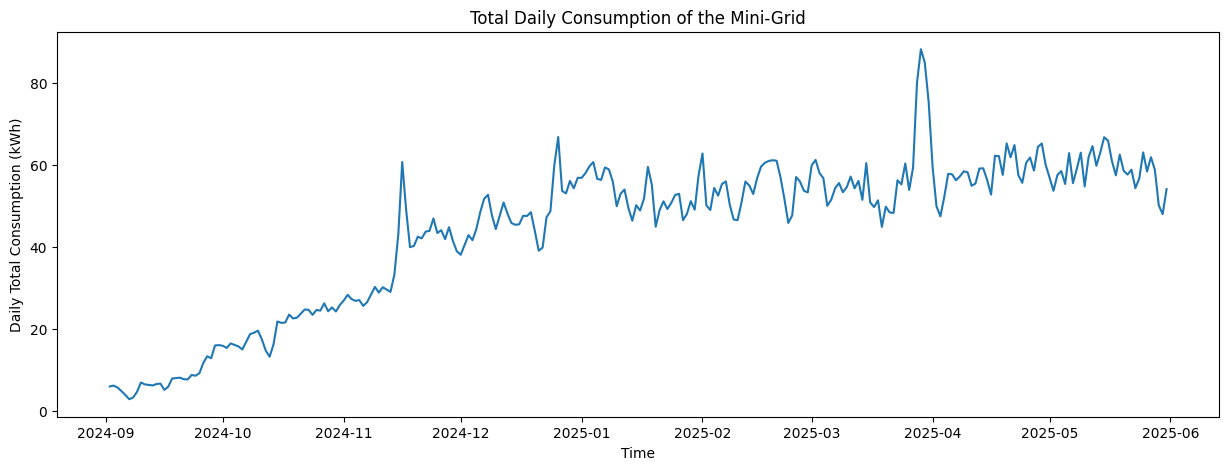

In [8]:
# Calculate total consumption per day

total_daily_consumption = df.groupby('Timestamp (UTC)')['Usage Amount'].sum().reset_index()

#Plot

plt.figure(figsize=(15,5))
sns.lineplot(data=total_daily_consumption, x='Timestamp (UTC)', y='Usage Amount')
plt.title('Total Daily Consumption of the Mini-Grid')
plt.xlabel('Time')
plt.ylabel('Daily Total Consumption (kWh)')
plt.show()

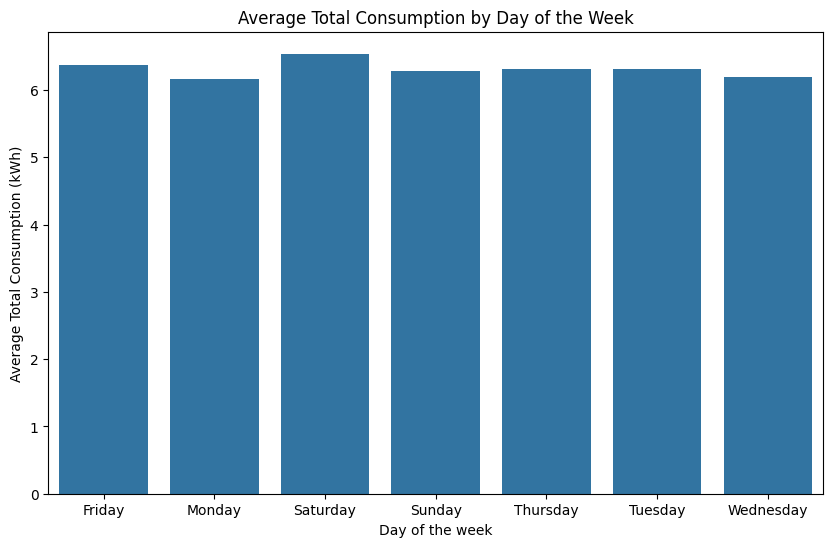

In [9]:
# Analyze comsumption by Day of the week

avg_comsumption_by_day = df.groupby('day_of_week')['Usage Amount'].sum()/df['Timestamp (UTC)'].nunique()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_comsumption_by_day.reindex(day_order)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_comsumption_by_day.index, y=avg_comsumption_by_day.values)
plt.title('Average Total Consumption by Day of the Week')
plt.xlabel('Day of the week')
plt.ylabel('Average Total Consumption (kWh)')
plt.show()

In [10]:
customer_metrics = df.groupby('Meter Number')['Usage Amount'].agg(
    avg_daily_kwh='mean',
    std_dev_kwh='std'
).reset_index()

weekend_consumption = df[df['is_weekend']].groupby('Meter Number')['Usage Amount'].mean()
weekday_consumption = df[~df['is_weekend']].groupby('Meter Number')['Usage Amount'].mean()

ratio_series = (weekend_consumption / weekday_consumption).fillna(1)

customer_metrics['weekend_weekday_ratio'] = customer_metrics['Meter Number'].map(ratio_series)

print("Customer Metrics")
customer_metrics.head(10)

Customer Metrics


,Meter Number,avg_daily_kwh,std_dev_kwh,weekend_weekday_ratio
0,240000029134,1.084320,0.704037,1.049797
1,240000029159,0.872797,0.233724,1.026061
2,240000029167,0.232411,0.056976,1.041951
3,240000029175,0.917712,0.499405,1.067378
4,240000029191,1.134669,1.124506,0.811102
5,240000029209,1.130843,0.236863,0.990211
6,240000029571,0.854138,0.099499,0.995210
7,240000029589,0.436366,0.118659,1.010944
8,240000029605,4.672615,1.338896,1.032495
9,240000029894,5.290332,1.558374,1.042214


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = customer_metrics[['avg_daily_kwh','std_dev_kwh', 'weekend_weekday_ratio']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kMeans = KMeans(n_clusters=5, random_state=42, n_init=20)
customer_metrics['cluster'] = kMeans.fit_predict(features_scaled)
print("Cutomers with their assigned cluster")
customer_metrics.head()


Cutomers with their assigned cluster


,Meter Number,avg_daily_kwh,std_dev_kwh,weekend_weekday_ratio,cluster
0,240000029134,1.084320,0.704037,1.049797,2
1,240000029159,0.872797,0.233724,1.026061,2
2,240000029167,0.232411,0.056976,1.041951,4
3,240000029175,0.917712,0.499405,1.067378,2
4,240000029191,1.134669,1.124506,0.811102,0


In [12]:
cluster_name_map = {
    3: 'Anchor Load',
    0: 'Power Household',
    2: 'Standard Household',
    4: 'Low Use / Business',
    1: 'Anomaly / Inactive'
}

customer_metrics['segment_name'] = customer_metrics['cluster'].map(cluster_name_map)

In [13]:
customer_metrics.head()

,Meter Number,avg_daily_kwh,std_dev_kwh,weekend_weekday_ratio,cluster,segment_name
0,240000029134,1.084320,0.704037,1.049797,2,Standard Household
1,240000029159,0.872797,0.233724,1.026061,2,Standard Household
2,240000029167,0.232411,0.056976,1.041951,4,Low Use / Business
3,240000029175,0.917712,0.499405,1.067378,2,Standard Household
4,240000029191,1.134669,1.124506,0.811102,0,Power Household


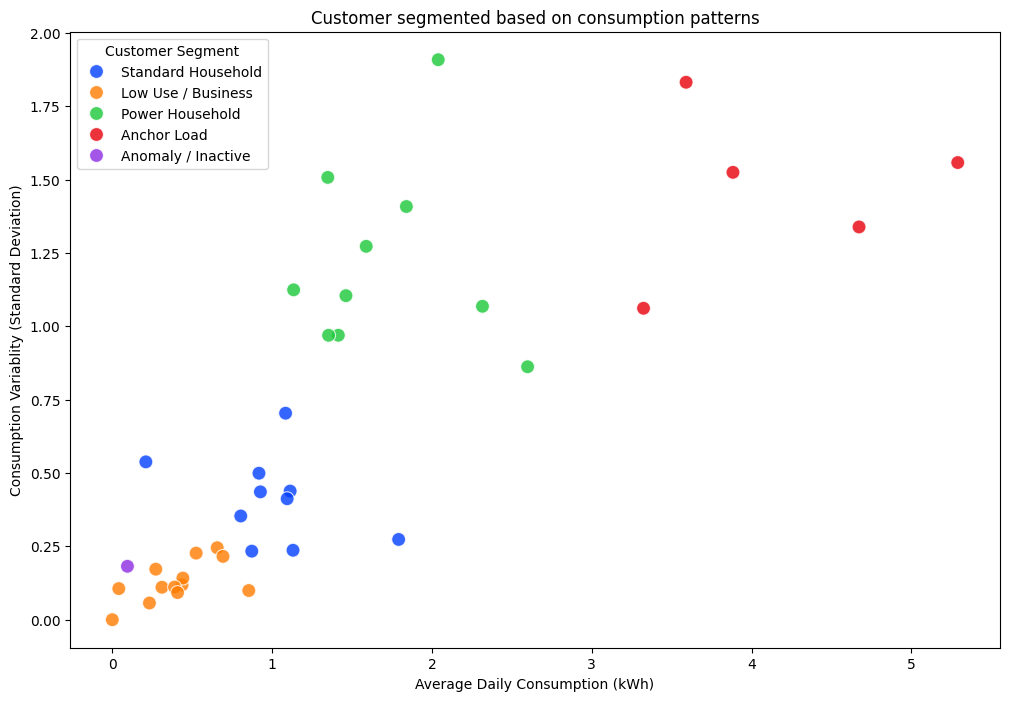

In [14]:
#visualize segments

plt.figure(figsize=(12,8))
sns.scatterplot(
    data=customer_metrics,
    x='avg_daily_kwh',
    y='std_dev_kwh',
    hue='segment_name',
    palette="bright",
    s=100,
    alpha=0.8
)
plt.title('Customer segmented based on consumption patterns')
plt.xlabel('Average Daily Consumption (kWh)')
plt.ylabel('Consumption Variablity (Standard Deviation)')
plt.legend(title='Customer Segment')
plt.show()

In [15]:
cluster_summary = customer_metrics.groupby('cluster')[['avg_daily_kwh', 'std_dev_kwh', 'weekend_weekday_ratio']].mean()
# print(cluster_summary)

In [45]:
data_loader_hour = Load_Dataset('2025.06.csv')
dfh = data_loader_hour.load_data()
dfh.shape

(142776, 3)

In [ ]:
dfh['Timestamp (UTC)'] = pd.to_datetime(dfh['Timestamp (UTC)']).dt.tz_localize(None).dt.strftime('%Y-%m-%d %H:%M:%S')


print(dfh['Timestamp (UTC)'].head(10))

0    2024-10-15 09:00:00
1    2024-10-15 10:00:00
2    2024-10-15 11:00:00
3    2024-10-15 12:00:00
4    2024-10-15 13:00:00
5    2024-10-15 14:00:00
6    2024-10-15 15:00:00
7    2024-10-15 16:00:00
8    2024-10-15 17:00:00
9    2024-10-15 18:00:00
Name: Timestamp (UTC), dtype: object


In [33]:
dfh['Timestamp (UTC)'] = pd.to_datetime(df['Timestamp (UTC)'], format='%Y-%m-%d %H:%M:%S')

In [50]:
dfh['Timestamp (UTC)'] = pd.to_datetime(dfh['Timestamp (UTC)'], format='%Y-%m-%d %H:%M:%S')

In [53]:
dfh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142776 entries, 0 to 142775
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Timestamp (UTC)  142776 non-null  datetime64[ns]
 1   Meter Number     142776 non-null  float64       
 2   Usage Amount     142776 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.3 MB


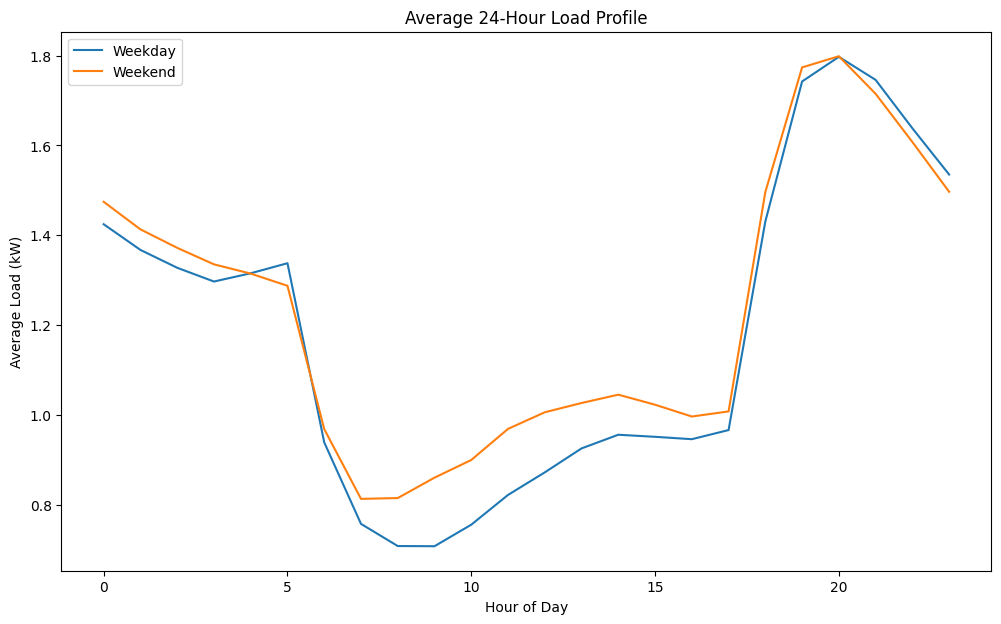

In [58]:
dfh['Hour'] = dfh['Timestamp (UTC)'].dt.hour
dfh['is_weekend'] = dfh['Timestamp (UTC)'].dt.dayofweek >= 5

total_hourly_load = dfh.groupby(['Timestamp (UTC)', 'Hour', 'is_weekend'])['Usage Amount'].sum().reset_index()

avg_load_profile = total_hourly_load.groupby(['is_weekend', 'Hour'])['Usage Amount'].mean().unstack(level=0)
avg_load_profile.columns = ['Weekday', 'Weekend']

avg_load_profile.plot(figsize=(12,7), title='Average 24-Hour Load Profile')
plt.xlabel('Hour of Day')
plt.ylabel('Average Load (kW)')
plt.show()

C:\Users\EEK\AppData\Local\Temp\ipykernel_1440\3277826617.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_load_profile = total_hourly_load.groupby(['is_weekend', 'Hour_bin'])['Usage Amount'].mean().unstack(level=0)


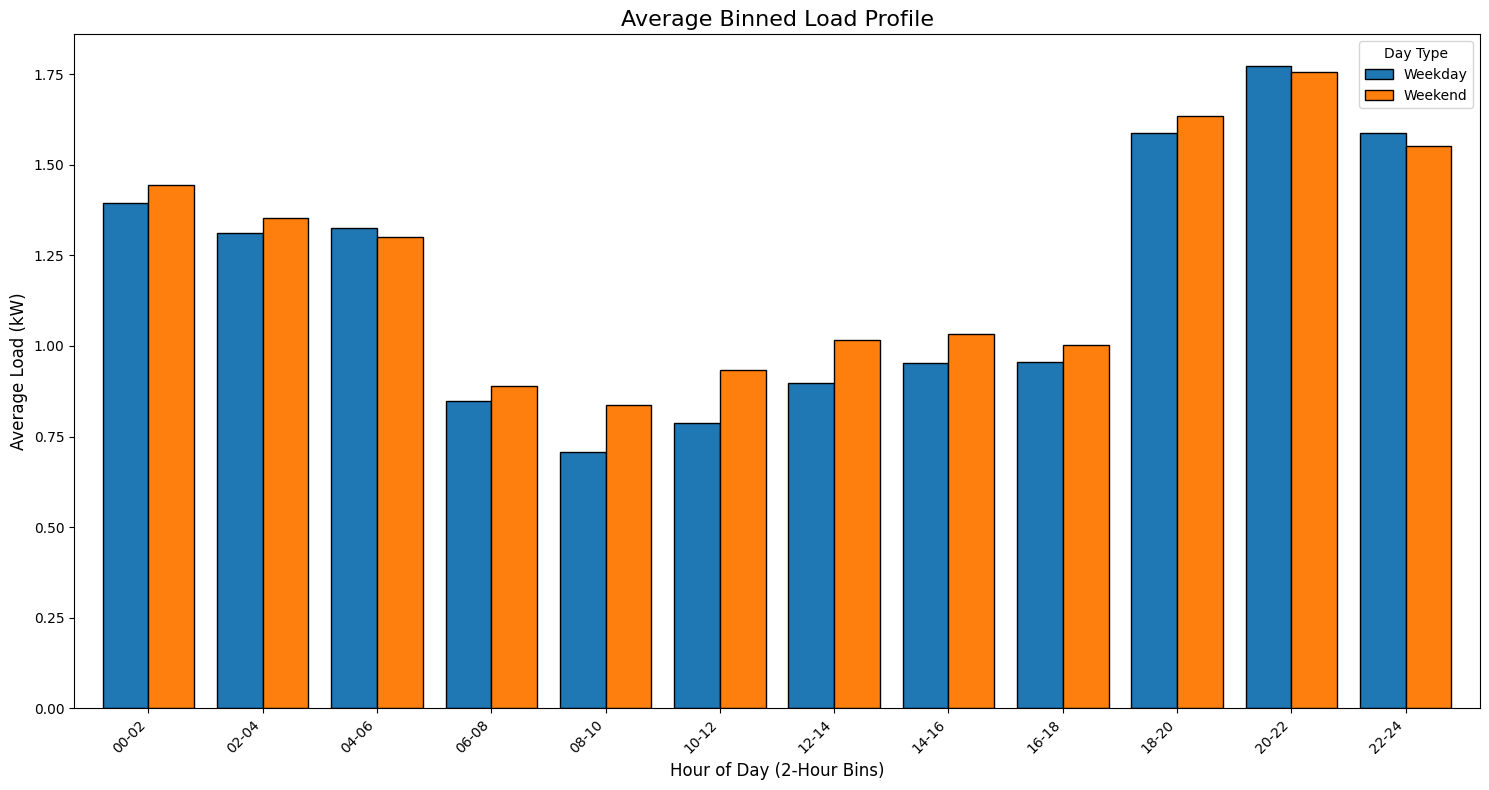

In [61]:
bins = range(0,25,2)
labels =[f"{i:02d}-{i+2:02d}" for i in bins[:-1]]

total_hourly_load['Hour_bin'] = pd.cut(total_hourly_load['Hour'], bins=bins, labels=labels, right=False)

binned_load_profile = total_hourly_load.groupby(['is_weekend', 'Hour_bin'])['Usage Amount'].mean().unstack(level=0)
binned_load_profile.columns = ['Weekday', 'Weekend']

binned_load_profile.plot(
    kind='bar',
    figsize=(15, 8),
    width=0.8, # Adjust the width of the bars
    edgecolor='black'
)

plt.title('Average Binned Load Profile', fontsize=16)
plt.xlabel('Hour of Day (2-Hour Bins)', fontsize=12)
plt.ylabel('Average Load (kW)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Day Type')
plt.tight_layout()
plt.show()